<a href="https://colab.research.google.com/github/Harisuryatm/Sample-Time-series-Model/blob/master/sample_Time_series_Deep_Neural_Network_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# installing tensorflow 2.0
!pip install tf-nightly-2.0-preview

     |████████████████████████████████| 95.2MB 45kB/s 
     |████████████████████████████████| 450kB 35.4MB/s 
     |████████████████████████████████| 3.8MB 32.7MB/s 
     |████████████████████████████████| 81kB 9.6MB/s 
ERROR: google-colab 1.0.0 has requirement google-auth~=1.4.0, but you'll have google-auth 1.11.0 which is incompatible.
ERROR: tb-nightly 2.1.0a20191206 has requirement grpcio>=1.24.3, but you'll have grpcio 1.15.0 which is incompatible.
  Found existing installation: google-auth 1.4.2
    Uninstalling google-auth-1.4.2:
      Successfully uninstalled google-auth-1.4.2


In [1]:
# Importing libraries that we gonna work with
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense

Using TensorFlow backend.


In [0]:
# getting data
# plotting
def plot_series(time,series,start=0,end=None,format='-',color=None):
  plt.plot(time[start:end],series[start:end],format,color=color)
  plt.xlabel('time')
  plt.ylabel('Value')
  plt.grid(True)

# trend 
def trend(time,slope=0):
  return time * slope

#seasonal pattern
def seasonal_pattern(season_time):
  return np.where(season_time < 0.2,
                  np.cos(season_time * 0.2 * np.pi),
                  1 / np.exp(3 * season_time))

# seasonality
def seasonality(time,period,amplitude=1,phase=0):
  season_time = ((time + phase) % period) / period
  return amplitude * seasonal_pattern(season_time)

def noise(time,noise_level,seed=1):
  rnd=np.random.RandomState(seed=seed)
  return rnd.randn(len(time)) * noise_level


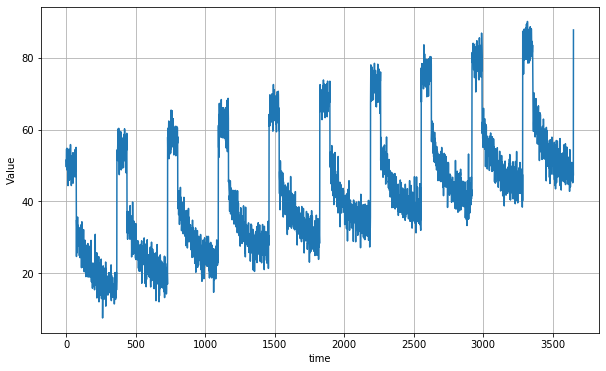

In [3]:
time = np.arange(10*365 + 1,dtype = 'float32')
series = trend(time,0.1)
baseline=10
slope = 0.01
amplitude = 40
noise_level = 3
series = baseline + trend(time,slope) + seasonality(time,period=365,amplitude=amplitude) + noise(time,noise_level,seed=42)
plt.figure(figsize=(10,6))
plot_series(time,series)

In [0]:
# splittng the dataset into training and Validation/testing
split_time = 3000

#train
time_train = time[:split_time]
x_train = series[:split_time]

#validation
time_valid = time[split_time:]
x_valid = series[split_time:]

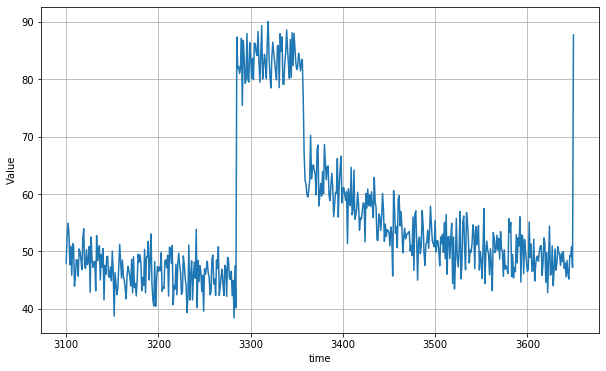

In [5]:
# plotting the validation data by zooming it
plt.figure(figsize=(10,6))
plot_series(time_valid,x_valid,start=100)

In [6]:
# changing the time series data to supervised
x_train[:30]

array([51.49014246, 49.5951482 , 51.96282956, 54.59855429, 49.33659093,
       49.34610826, 54.7955074 , 52.3694009 , 48.66778686, 51.71288139,
       48.70381736, 48.70563972, 50.83734845, 44.38014294, 44.95363014,
       48.44980276, 47.10633162, 51.09561218, 47.43672489, 45.9316947 ,
       54.57324254, 49.50653569, 50.39390313, 45.9244058 , 48.57271578,
       50.54573087, 46.76695945, 51.35389688, 48.43162733, 49.36508828])

In [0]:
window_size = 30
batch_size = 42

In [0]:
# Time series to supervised learning
def window_sequence(series,window_size,batch_size):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1,shift=1,drop_remainder=True)
  dataset = dataset.flat_map(lambda window:window.batch(window_size+1))
  dataset = dataset.map(lambda window : (window[:-1],window[-1:]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset


In [0]:
dataset = window_sequence(x_train,window_size,batch_size)

In [0]:
# Deep Neural Network
model = tf.keras.models.Sequential(
    [tf.keras.layers.Dense(100,input_shape=[window_size],activation='relu'),
     tf.keras.layers.Dense(10,activation = 'relu'),
     tf.keras.layers.Dense(1)
    ])


In [0]:
# Compile
model.compile(loss='mse',optimizer=tf.keras.optimizers.SGD(learning_rate=1e-6,momentum=0.9))

In [0]:
# training the model using training data
history = model.fit(dataset,epochs=100,verbose=0)

In [0]:
# forecast
forecast = []
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


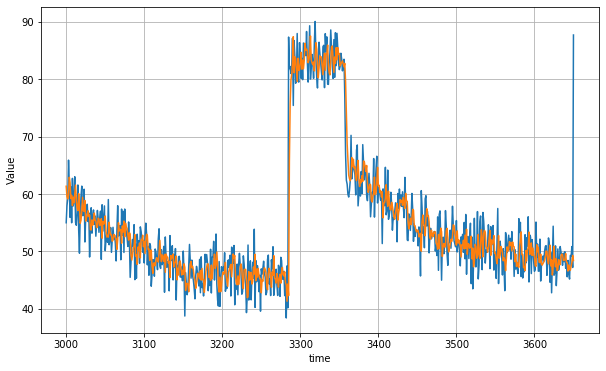

In [28]:
plt.figure(figsize=(10,6))
plot_series(time_valid,x_valid)
plot_series(time_valid,results)

In [33]:
print(keras.metrics.mean_absolute_error(x_valid,results).numpy())

3.0923536
